In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import polars as pl
import sys
sys.path.append('../../dspy')

In [3]:
#!uv pip install -e ../../dspy

In [4]:
from dspy.hdb import get_dataset
from cooc.plots import plot_trades
from cooc.features import coi
from cooc.classify import classify_trades


# <font color="grey">Trade decomposition</font>

### <font color="grey">  Table of Contents</font>

1. #### <a href='#chapter1'>Data</a>
2. #### <a href='#chapter2'>Trade decomposition</a>

###  <a id='chapter1'> <font color="grey">1. Data </font></a>

Data is currently available for 5 products, namely perpetual futures contracts for the following pairs: BTC-USDT, ETH-USDT, SOL-USDT, DOGE-USDT and LINK-USDT. The details on these products are not important for the time being, they just represent time series. Data is available for trades and quotes (level 1 limit order book) for a period from June to end of August. For each month, the data begins at 00:01 of the first day and ends at 23:50.

The timestamps are given in nanosecond resolution as Unix timestamps, but the granularity of the data is not that fine. A simple dataloader and some helper function to convert Python datetime objects or strings of the form '240802.1450' into timestamps are provided. The 'book' data contains best bid and ask prices with corresponding volumes. The 'trade' data contains trades, with a signed quantity representing direction. There is also an associated trade id in order to identify individual trades.

The book data is mainly to determine the price movements and for potential backtests. In the original dataset there are more timestamps (depending on when the data was sent or received) but I don't think this matters at the moment. One could try to align what happens in the trades with what happens in the book dataset.

We make heavy use of [polars](https://pola.rs/), for the simple reason of performance. If one is not used to it, the learning curve can be steep but it will make things quicker in the long run. We also work with polars extensions to easily add features to the data.

In [7]:
dl = get_dataset("tardis", root="../../dspy/data/tardis/")

In [8]:
RCS = [f"{coin}USDT" for coin in ["BTC", "ETH", "SOL", "DOGE", "LINK"]]
TYPE = ['book', 'trade']
MONTHS = ['06', '07', '08']
TIMES = ['240720.000100', '240725.235000']

In [9]:
df = dl.load_book(RCS[0:2], TIMES, lazy=True)
# Add human readable timestamp and mid prices
df = df.ds.add_datetime('ts').feature.add_mid(products=RCS[0:2])

In [11]:
# This takes some time, not because of the loading but because of the aggregation
df = df.collect()
df.head()

ts,prc__s0_BTCUSDT,prc__s1_BTCUSDT,vol__s0_BTCUSDT,vol__s1_BTCUSDT,prc__s0_ETHUSDT,prc__s1_ETHUSDT,vol__s0_ETHUSDT,vol__s1_ETHUSDT,dts,mid_BTCUSDT,mid_ETHUSDT
u64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64
1721433660056500000,66689.9,66690.0,7.331,10.59,3503.63,3503.64,12.785,82.869,2024-07-20 00:01:00.056500,66689.95,3503.635
1721433660058500000,66689.9,66690.0,7.331,10.531,3503.63,3503.64,12.785,82.869,2024-07-20 00:01:00.058500,66689.95,3503.635
1721433660063500000,66689.9,66690.0,7.329,10.531,3503.63,3503.64,0.332,82.869,2024-07-20 00:01:00.063500,66689.95,3503.635
1721433660066500000,66689.9,66690.0,6.079,10.531,3503.63,3503.64,0.332,82.883,2024-07-20 00:01:00.066500,66689.95,3503.635
1721433660069500000,66689.9,66690.0,6.079,10.513,3503.63,3503.64,0.332,82.883,2024-07-20 00:01:00.069500,66689.95,3503.635


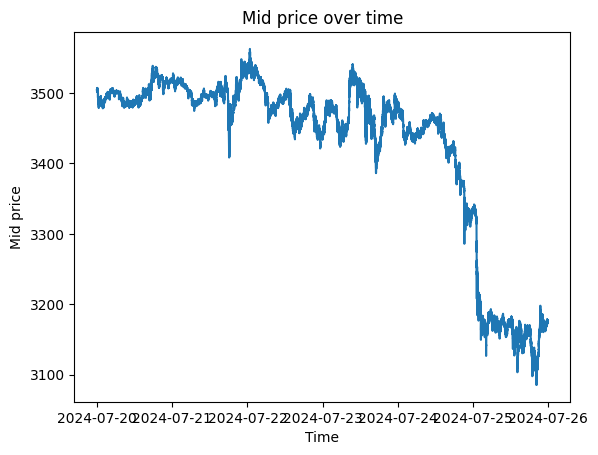

In [12]:
plt.plot(df['dts'], df['mid_ETHUSDT'])
plt.xlabel('Time')
plt.ylabel('Mid price')
plt.title('Mid price over time')
plt.show()

In [13]:
tdf = dl.load_trades(RCS[0:2], TIMES, lazy=True)
# By default, the timestamp column is named 'ts'
tdf = tdf.trade.agg_trades().trade.add_side().ds.add_datetime()

In [14]:
# Just to check that it works
tdf = tdf.collect()
tdf.head()

ts,prc,product,trade_id,qty,side,dts
u64,f64,str,u64,f64,i32,datetime[ns]
1721433660058500000,66690.0,"""BTCUSDT""",5185491785,0.059,1,2024-07-20 00:01:00.058500
1721433660069500000,66690.0,"""BTCUSDT""",5185491786,0.018,1,2024-07-20 00:01:00.069500
1721433660157500000,66690.0,"""BTCUSDT""",5185491787,0.003,1,2024-07-20 00:01:00.157500
1721433660303500000,3503.64,"""ETHUSDT""",4221078684,0.014,1,2024-07-20 00:01:00.303500
1721433660481500000,3503.63,"""ETHUSDT""",4221078685,-0.006,-1,2024-07-20 00:01:00.481500


###  <a id='chapter2'> <font color="grey">2. Trade decomposition </font></a>

In [15]:
# Create a simple dataframe to test the trade classification
prods = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']
delta = "30s"
data = {
    "ts": [
        "2025-02-23 09:00:00",
        "2025-02-23 09:00:00",
        "2025-02-23 09:00:10",
        "2025-02-23 09:00:20",
        "2025-02-23 09:00:40",
        "2025-02-23 09:01:40",
        "2025-02-23 09:02:30",
        "2025-02-23 09:02:40",
        "2025-02-23 09:03:30",
        "2025-02-23 09:03:40"
    ],
    "product": [
        "BTCUSDT", "SOLUSDT", "SOLUSDT", "ETHUSDT", "BTCUSDT",
        "ETHUSDT", "ETHUSDT", "BTCUSDT", "SOLUSDT", "SOLUSDT"
    ],
    "trade_id": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "prc": [100, 102, 101, 103, 104, 103, 101, 100, 99, 98],
    "qty": [10, 15, 12, 20, -18, 21, -15, 12, -10, 10]
}

df = pl.DataFrame(data)
df = df.with_columns(
    pl.col("ts").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S")
)

print(df)

shape: (10, 5)
┌─────────────────────┬─────────┬──────────┬─────┬─────┐
│ ts                  ┆ product ┆ trade_id ┆ prc ┆ qty │
│ ---                 ┆ ---     ┆ ---      ┆ --- ┆ --- │
│ datetime[μs]        ┆ str     ┆ i64      ┆ i64 ┆ i64 │
╞═════════════════════╪═════════╪══════════╪═════╪═════╡
│ 2025-02-23 09:00:00 ┆ BTCUSDT ┆ 0        ┆ 100 ┆ 10  │
│ 2025-02-23 09:00:00 ┆ SOLUSDT ┆ 1        ┆ 102 ┆ 15  │
│ 2025-02-23 09:00:10 ┆ SOLUSDT ┆ 2        ┆ 101 ┆ 12  │
│ 2025-02-23 09:00:20 ┆ ETHUSDT ┆ 3        ┆ 103 ┆ 20  │
│ 2025-02-23 09:00:40 ┆ BTCUSDT ┆ 4        ┆ 104 ┆ -18 │
│ 2025-02-23 09:01:40 ┆ ETHUSDT ┆ 5        ┆ 103 ┆ 21  │
│ 2025-02-23 09:02:30 ┆ ETHUSDT ┆ 6        ┆ 101 ┆ -15 │
│ 2025-02-23 09:02:40 ┆ BTCUSDT ┆ 7        ┆ 100 ┆ 12  │
│ 2025-02-23 09:03:30 ┆ SOLUSDT ┆ 8        ┆ 99  ┆ -10 │
│ 2025-02-23 09:03:40 ┆ SOLUSDT ┆ 9        ┆ 98  ┆ 10  │
└─────────────────────┴─────────┴──────────┴─────┴─────┘


In [18]:
tdf = classify_trades(df, prods, "ts", "30s")
tdf

ts,product,trade_id,prc,qty,trade_type
datetime[μs],str,i64,i64,i64,str
2025-02-23 09:00:00,"""BTCUSDT""",0,100,10,"""nis-c"""
2025-02-23 09:00:00,"""SOLUSDT""",1,102,15,"""nis-b"""
2025-02-23 09:00:10,"""SOLUSDT""",2,101,12,"""nis-b"""
2025-02-23 09:00:20,"""ETHUSDT""",3,103,20,"""nis-c"""
2025-02-23 09:00:40,"""BTCUSDT""",4,104,-18,"""nis-c"""
2025-02-23 09:01:40,"""ETHUSDT""",5,103,21,"""iso"""
2025-02-23 09:02:30,"""ETHUSDT""",6,101,-15,"""nis-c"""
2025-02-23 09:02:40,"""BTCUSDT""",7,100,12,"""nis-c"""
2025-02-23 09:03:30,"""SOLUSDT""",8,99,-10,"""nis-s"""


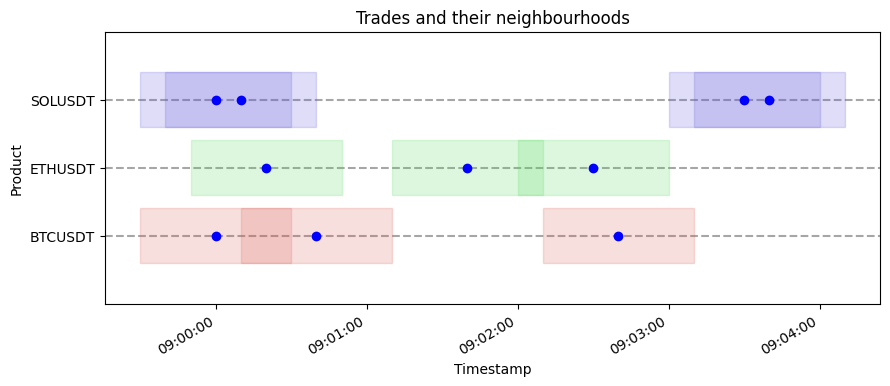

In [19]:
plot_trades(tdf, ['BTCUSDT', 'ETHUSDT', 'SOLUSDT'], 'ts', '250223.090000', 10, '30s')

In [20]:
cdf = coi(tdf, "ts", "60s", "nis-c")
print(cdf)

shape: (10, 7)
┌─────────────────────┬─────────┬──────────┬─────┬─────┬────────────┬──────────────┐
│ ts                  ┆ product ┆ trade_id ┆ prc ┆ qty ┆ trade_type ┆ coi_nis-c_1m │
│ ---                 ┆ ---     ┆ ---      ┆ --- ┆ --- ┆ ---        ┆ ---          │
│ datetime[μs]        ┆ str     ┆ i64      ┆ i64 ┆ i64 ┆ str        ┆ f64          │
╞═════════════════════╪═════════╪══════════╪═════╪═════╪════════════╪══════════════╡
│ 2025-02-23 09:00:00 ┆ BTCUSDT ┆ 0        ┆ 100 ┆ 10  ┆ nis-c      ┆ 0.0          │
│ 2025-02-23 09:00:00 ┆ SOLUSDT ┆ 1        ┆ 102 ┆ 15  ┆ nis-b      ┆ 0.0          │
│ 2025-02-23 09:00:10 ┆ SOLUSDT ┆ 2        ┆ 101 ┆ 12  ┆ nis-b      ┆ 1.0          │
│ 2025-02-23 09:00:20 ┆ ETHUSDT ┆ 3        ┆ 103 ┆ 20  ┆ nis-c      ┆ 1.0          │
│ 2025-02-23 09:00:40 ┆ BTCUSDT ┆ 4        ┆ 104 ┆ -18 ┆ nis-c      ┆ 1.0          │
│ 2025-02-23 09:01:40 ┆ ETHUSDT ┆ 5        ┆ 103 ┆ 21  ┆ iso        ┆ -1.0         │
│ 2025-02-23 09:02:30 ┆ ETHUSDT ┆ 6        ┆ 101 ┆

In [22]:
# Now for some real data
df = dl.load_trades(RCS, ['240707.0800', '240707.2200']).ds.add_datetime('ts')

In [23]:
# Aggregate trades by timestamp and price and add human readable timestamp
tdf = df.trade.agg_trades().ds.add_datetime('ts')
tdf.head()

ts,prc,product,trade_id,qty,dts
u64,f64,str,u64,f64,datetime[ns]
1720339200013500000,0.10995,"""DOGEUSDT""",1788181660,13502.0,2024-07-07 08:00:00.013500
1720339200057500000,3002.98,"""ETHUSDT""",4179414149,0.185,2024-07-07 08:00:00.057500
1720339200063500000,3002.98,"""ETHUSDT""",4179414150,0.022,2024-07-07 08:00:00.063500
1720339200068500000,3002.98,"""ETHUSDT""",4179414151,1.0,2024-07-07 08:00:00.068500
1720339200080500000,3002.98,"""ETHUSDT""",4179414154,0.655,2024-07-07 08:00:00.080500


In [24]:
tdf = classify_trades(tdf, RCS, "dts", "5ms")
tdf.head()

ts,prc,product,trade_id,qty,dts,trade_type
u64,f64,str,u64,f64,datetime[ns],str
1720339200013500000,0.10995,"""DOGEUSDT""",1788181660,13502.0,2024-07-07 08:00:00.013500,"""iso"""
1720339200057500000,3002.98,"""ETHUSDT""",4179414149,0.185,2024-07-07 08:00:00.057500,"""iso"""
1720339200063500000,3002.98,"""ETHUSDT""",4179414150,0.022,2024-07-07 08:00:00.063500,"""nis-s"""
1720339200068500000,3002.98,"""ETHUSDT""",4179414151,1.0,2024-07-07 08:00:00.068500,"""nis-s"""
1720339200080500000,3002.98,"""ETHUSDT""",4179414154,0.655,2024-07-07 08:00:00.080500,"""nis-s"""


In [25]:
cdf = coi(tdf, "dts", "5m", "nis-c")
cdf.tail()

ts,prc,product,trade_id,qty,dts,trade_type,coi_nis-c_5m
u64,f64,str,u64,f64,datetime[ns],str,f64
1720389599755500000,56566.4,"""BTCUSDT""",5144903591,-0.002,2024-07-07 21:59:59.755500,"""nis-s""",-0.162795
1720389599755500000,56566.1,"""BTCUSDT""",5144903592,-2.02,2024-07-07 21:59:59.755500,"""nis-s""",-0.162795
1720389599755500000,56566.0,"""BTCUSDT""",5144903595,-0.179,2024-07-07 21:59:59.755500,"""nis-s""",-0.162795
1720389599755500000,56565.8,"""BTCUSDT""",5144903597,-1.792,2024-07-07 21:59:59.755500,"""nis-s""",-0.162795
1720389599999500000,134.246,"""SOLUSDT""",1649565674,2.0,2024-07-07 21:59:59.999500,"""iso""",-0.162795
